In [1]:
import sys
import time

import numpy as np
import matplotlib
import torch

%matplotlib inline
print(f"Python version: {sys.version}\nNumpy version: {np.__version__}\nMatplotlib version: {matplotlib.__version__}\nPyTorch version: {torch.__version__}")

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy version: 1.26.4
Matplotlib version: 3.8.0
PyTorch version: 2.2.1


# Problem 6

In [2]:
MNIST_DATA_PATH = '../../Lectures Slides {MFDNN}/Notebooks {MFDNN}/mnist_data'

## Copied code from `Chapter 2 Code.ipynb`

### Data set up

In [3]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from random import shuffle


# Use data with only 4 and 9 as labels: which is hardest to classify
label_1, label_2 = 4, 9

# MNIST training data
train_set = datasets.MNIST(root=MNIST_DATA_PATH, train=True, transform=transforms.ToTensor(), download=True)

# Use data with two labels
idx = (train_set.targets == label_1) + (train_set.targets == label_2)
train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]
train_set.targets[train_set.targets == label_1] = -1
train_set.targets[train_set.targets == label_2] = 1

# MNIST testing data
test_set = datasets.MNIST(root=MNIST_DATA_PATH, train=False, transform=transforms.ToTensor())

# Use data with two labels
idx = (test_set.targets == label_1) + (test_set.targets == label_2)
test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]
test_set.targets[test_set.targets == label_1] = -1
test_set.targets[test_set.targets == label_2] = 1

In [4]:
device = "cpu"

### Logistic Regression Model

In [5]:
class LR(nn.Module):
    def __init__(self, input_dim=28*28):
        super().__init__()
        self.linear_layer = nn.Linear(input_dim, 1, bias=False)  # change code from copied - we want to use bias (b) given in Q

    def forward(self, x):
        return self.linear_layer(x.float().view(-1, 28*28))

In [15]:
def logistic_loss(output, target):  # equivalent to minimising KL-divergence (see Chapter 2)
    # reshaping and mean necessary for enabling of batch processing
    return torch.mean(-torch.nn.functional.logsigmoid(target.reshape(-1)*output.reshape(-1)))

def sum_of_squares_loss(output, target):
    # label 4 = -1, label 9 = 1
    loss_4 = (torch.square(1 - torch.sigmoid(-output.reshape(-1))) + torch.square(torch.sigmoid(output.reshape(-1))))
    loss_9 = (torch.square(torch.sigmoid(-output.reshape(-1))) + torch.square(1 - torch.sigmoid(output.reshape(-1))))
    return torch.mean(
        0.5 * (1 - target.reshape(-1)) * loss_4
      + 0.5 * (1 + target.reshape(-1)) * loss_9
    )

In [20]:
# testing loss function works as expected
print(sum_of_squares_loss(torch.as_tensor([1000000]), torch.as_tensor([-1])))              # label incorrect
print(sum_of_squares_loss(torch.as_tensor([-1000000]), torch.as_tensor([-1])))             # label correct
print(sum_of_squares_loss(torch.as_tensor([1000000]), torch.as_tensor([1])))               # label correct
print(sum_of_squares_loss(torch.as_tensor([-1000000]), torch.as_tensor([1])))              # label incorrect

print(sum_of_squares_loss(torch.as_tensor([1000000, -100000]), torch.as_tensor([1, -1])))  # both labels correct

tensor(2.)
tensor(0.)
tensor(0.)
tensor(2.)
tensor(0.)


In [21]:
def plot_loss(loss_array):
    """Plot the recorded loss (assumed per iteration)"""
    n = len(loss_array)
    plt.plot(range(n), loss_array, 'r')
    plt.xlabel('Iterations')
    plt.ylabel('Average test set loss')
    plt.ylim(0, np.max(loss_array)*1.1)
    plt.title('Average test loss over successive iterations')
    plt.show()

In [22]:
def test_performance(model, loss_function):
    test_loss, correct = 0, 0
    
    # Test data
    test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)
    # no need to shuffle test data
    
    for ind, (image, label) in enumerate(test_loader) :
        image, label = image.to(device), label.to(device)
        
        output = model(image)
    
        test_loss += loss_function(output, label.float()).item()
    
        if output.item() * label.item() >= 0 :
            correct += 1
    
    return test_loss/len(test_loader), 100. * correct/len(test_loader)

In [23]:
def train_model(loss_function, num_epochs=30, alpha=255*1e-4):
    lr_model = LR().to(device)
    optimizer = torch.optim.SGD(lr_model.parameters(), lr=alpha)   # specify SGD with learning rate
    
    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
    test_loss = []
    
    start = time.time()
    for epoch_k in range(num_epochs):
        print(f"Starting epoch {epoch_k+1:>5}/{num_epochs}", end='\r')
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
    
            train_loss = loss_function(lr_model(images).to(device), labels.float())
            train_loss.backward()
    
            optimizer.step()
        test_loss.append(test_performance(lr_model, loss_function)[0])
    end = time.time()
    print(f"Time elapsed in training is: {end - start}")
    print(f"Final accuracy: {test_performance(lr_model, loss_function)[1]:.2f}%")
    return lr_model, test_loss

Training model using logistic loss
Time elapsed in training is: 11.294185161590576
Final accuracy: 96.03%


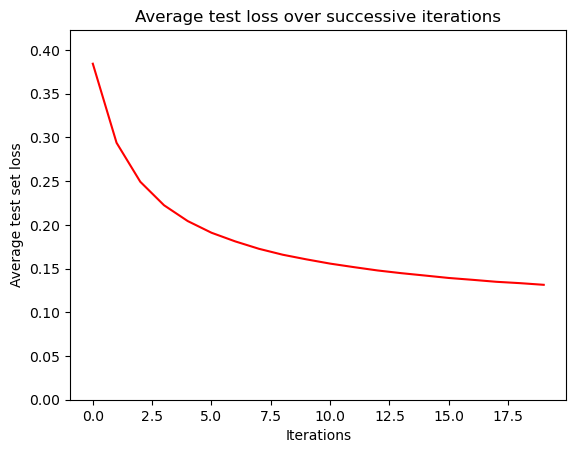

In [11]:
print("Training model using logistic loss")
logistic_model, test_loss = train_model(logistic_loss, 20, 0.01)
plot_loss(test_loss)

Training model using sum of squares loss
Time elapsed in training is: 13.514590978622437
Final accuracy: 95.88%


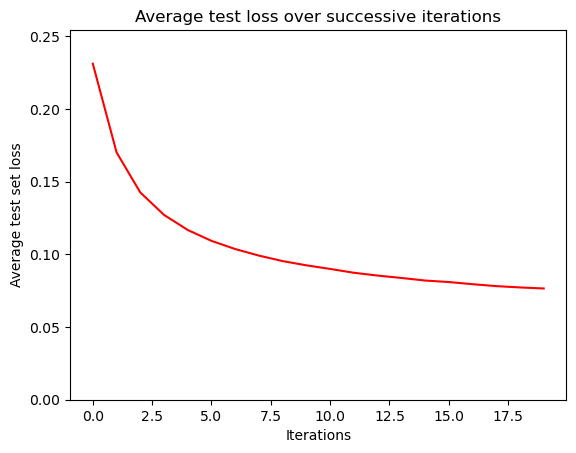

In [25]:
print("Training model using sum of squares loss")
sos_model, test_loss = train_model(sum_of_squares_loss, 20, 0.01)
plot_loss(test_loss)

# Problem 7

In [138]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

'''
Step 1:
'''

# MNIST dataset
train_dataset = datasets.MNIST(root=MNIST_DATA_PATH,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root=MNIST_DATA_PATH,
                              train=False,
                              transform=transforms.ToTensor())


'''
Step 2: LeNet5
'''

# Modern LeNet uses this layer for C3
class C3_layer_full(nn.Module):
    def __init__(self):
        super(C3_layer_full, self).__init__()
        self.conv_layer = nn.Conv2d(6, 16, kernel_size=5)

    def forward(self, x):
        return self.conv_layer(x)

# Original LeNet uses this layer for C3
class C3_layer(nn.Module):
    def __init__(self):
        super(C3_layer, self).__init__()
        print('using subset layer')
        self.ch_in_3 = [[0, 1, 2],
                        [1, 2, 3],
                        [2, 3, 4],
                        [3, 4, 5],
                        [0, 4, 5],
                        [0, 1, 5]] # filter with 3 subset of input channels
        self.ch_in_4 = [[0, 1, 2, 3],
                        [1, 2, 3, 4],
                        [2, 3, 4, 5],
                        [0, 3, 4, 5],
                        [0, 1, 4, 5],
                        [0, 1, 2, 5],
                        [0, 1, 3, 4],
                        [1, 2, 4, 5],
                        [0, 2, 3, 5]] # filter with 4 subset of input channels
        self.ch_in_6 = [[i for i in range(6)]]  # filter with all 6 input channels
        self.input_channel_subsets = self.ch_in_3 + self.ch_in_4 + self.ch_in_6
        self.channels = nn.ModuleList([nn.Conv2d(len(input_ch), 1, kernel_size=5) for input_ch in self.input_channel_subsets])

    def forward(self, x):
        output = torch.Tensor().to(device)
        for conv, input_channels in zip(self.channels, self.input_channel_subsets):
            conv_channel_output = conv(x[:, input_channels, :, :])
            output = torch.cat([output, conv_channel_output.to(device)], dim=1)  # concatenate in channel (2nd) dimension
        return output

class LeNet(nn.Module) :
    def __init__(self, variety='full') :
        super(LeNet, self).__init__()
        #padding=2 makes 28x28 image into 32x32
        self.C1_layer = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.Tanh()
        )
        self.P2_layer = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh()
        )
        
        if variety == 'full':
            self.C3_layer = nn.Sequential(
                C3_layer_full(),
                nn.Tanh()
            )
        elif variety == 'subset':
            self.C3_layer = nn.Sequential(
                C3_layer(),
                nn.Tanh()
            )
        else:
            raise NotImplementedError('One of either `full` or `subset` is required for variety argument.')
            
        self.P4_layer = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh()
        )
        self.C5_layer = nn.Sequential(
            nn.Linear(5*5*16, 120),
            nn.Tanh()
        )
        self.F6_layer = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh()
        )
        self.F7_layer = nn.Linear(84, 10)
        self.tanh = nn.Tanh()

    def forward(self, x) :
        output = self.C1_layer(x)
        output = self.P2_layer(output)
        output = self.C3_layer(output)
        output = self.P4_layer(output)
        output = output.view(-1,5*5*16)
        output = self.C5_layer(output)
        output = self.F6_layer(output)
        output = self.F7_layer(output)
        return output
    
print(f'Pytorch using device="{device}"')

Pytorch using device="mps"


In [139]:
'''
Step 3
'''
def run_train_test_results(model):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
    
    # print total number of trainable parameters
    param_ct = sum([p.numel() for p in model.parameters()])
    print(f"Total number of trainable parameters: {param_ct}")
    
    '''
    Step 4
    '''
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
    
    import time
    start = time.time()
    for epoch in range(10) :
        print("{}th epoch starting.".format(epoch))
        for images, labels in train_loader :
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            train_loss = loss_function(model(images), labels)
            train_loss.backward()
    
            optimizer.step()
    end = time.time()
    print("Time elapsed in training is: {}".format(end - start))
    
    
    '''
    Step 5
    '''
    test_loss, correct, total = 0, 0, 0
    
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
    
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)
    
        output = model(images)
        test_loss += loss_function(output, labels).item()
    
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
    
        total += labels.size(0)
    
    print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

In [140]:
full_model = LeNet('full').to(device)
run_train_test_results(full_model)

Total number of trainable parameters: 61706
0th epoch starting.
1th epoch starting.
2th epoch starting.
3th epoch starting.
4th epoch starting.
5th epoch starting.
6th epoch starting.
7th epoch starting.
8th epoch starting.
9th epoch starting.
Time elapsed in training is: 47.253567934036255
[Test set] Average loss: 0.0005, Accuracy: 9830/10000 (98.30%)


In [141]:
subset_model = LeNet('subset').to(device)
run_train_test_results(subset_model)

using subset layer
Total number of trainable parameters: 60806
0th epoch starting.
1th epoch starting.
2th epoch starting.
3th epoch starting.
4th epoch starting.
5th epoch starting.
6th epoch starting.
7th epoch starting.
8th epoch starting.
9th epoch starting.
Time elapsed in training is: 172.8651237487793
[Test set] Average loss: 0.0004, Accuracy: 9859/10000 (98.59%)


Observed reduction of $61706-60806=900$ trainable parameters.

*The dimensions of each convolution's filter are given in order $\left(C_{out}, C_{in}, k_x, k_y\right)$ (see Chp. 3, slide 7)*

In the regular convolution, there is one filter with dimension $\left(16, 6, 5, 5\right)$ giving **2400** trainable weight parameters.

In the subset variation, there are 16 separate convolution filters:
- 6 with dimension $\left(1, 3, 5, 5\right)$ for **450** weights total, 
- 9 with dimension $\left(1, 4, 5, 5\right)$ for **900** weights total, and
- 1 with dimension $\left(1, 6, 5, 5\right)$ for **150** weights total.

So the expected difference in trainable parameters is $2400-(450+900+150)=900$ which matches the print statement output!